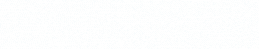

#**MVJ College of Engineering Under Visvesvaraya Technological University**
###**Department of Electronics and Communication Engineering**

###**Model Training Script**


---


This Model Training Script is created as a part of 8th Semester Major-Project.

Team Name  - Team OneShot

1MJ18EC122 - Satyam Oza R

1MJ18EC123 - Shankar S

1MJ18EC126 - Shireesha D C

1MJ18EC146 - Vedashree H A

### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Glaucoma_Detection'

Mounted at /content/drive
/content/drive/My Drive/Glaucoma_Detection


### Import all dependencies

In [ ]:
# importing dependencies

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from builtins import range, input
from sklearn.metrics import confusion_matrix, roc_curve

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout

### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = 224 

# training config:
epochs = 500
batch_size = 32
normalization_factor = 255

#define paths
glaucoma_positive_train_path = '/content/drive/My Drive/Glaucoma_Detection/Dataset/Train/Glaucoma_Positive'
glaucoma_negative_train_path = '/content/drive/My Drive/Glaucoma_Detection/Dataset/Train/Glaucoma_Negative'

glaucoma_positive_test_path = '/content/drive/My Drive/Glaucoma_Detection/Dataset/Test/Glaucoma_Positive'
glaucoma_negative_test_path = '/content/drive/My Drive/Glaucoma_Detection/Dataset/Test/Glaucoma_Negative'

# Use glob to grab images from path .jpg or jpeg
glaucoma_positive_train_files = glob(glaucoma_positive_train_path + '/*')
glaucoma_negative_train_files = glob(glaucoma_negative_train_path + '/*')

glaucoma_positive_test_files = glob(glaucoma_positive_test_path + '/*')
glaucoma_negative_test_files = glob(glaucoma_negative_test_path + '/*')


### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Preparing Train Labels
glaucoma_positive_train_labels = []
glaucoma_negative_train_labels = []

glaucoma_positive_train_images=[]
glaucoma_negative_train_images=[]

# Preparing Test Labels
glaucoma_positive_test_labels = []
glaucoma_negative_test_labels = []

glaucoma_positive_test_images=[]
glaucoma_negative_test_images=[]

for i in range(len(glaucoma_positive_train_files)):
  image = cv2.imread(glaucoma_positive_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_train_images.append(image)
  glaucoma_positive_train_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_train_files)):
  image = cv2.imread(glaucoma_negative_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_train_images.append(image)
  glaucoma_negative_train_labels.append('Glaucoma Negative')

for i in range(len(glaucoma_positive_test_files)):
  image = cv2.imread(glaucoma_positive_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_test_images.append(image)
  glaucoma_positive_test_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_test_files)):
  image = cv2.imread(glaucoma_negative_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_test_images.append(image)
  glaucoma_negative_test_labels.append('Glaucoma Negative')

### Visualize First 40 Images from Data set

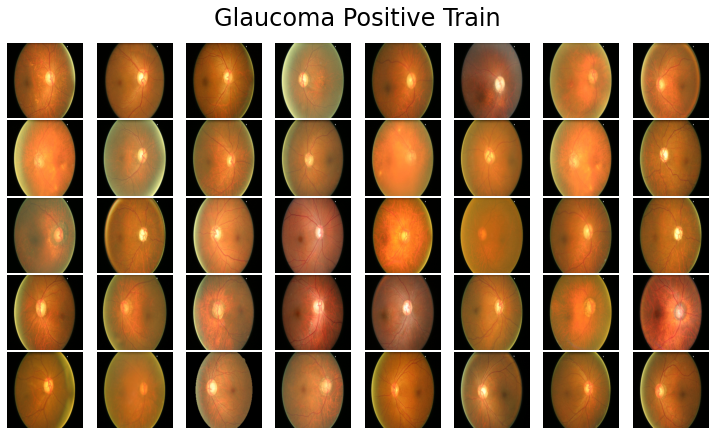

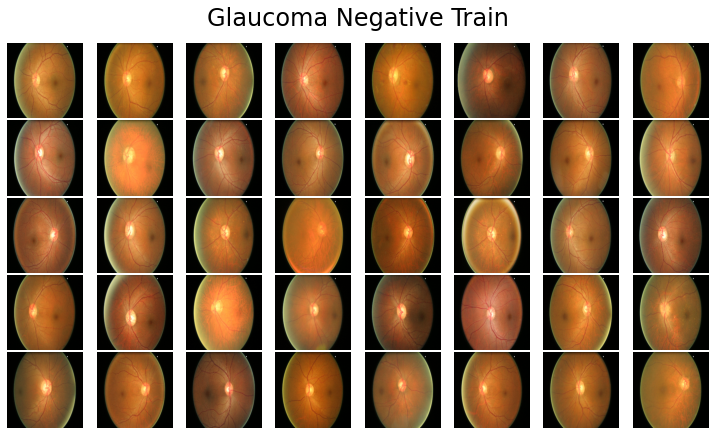

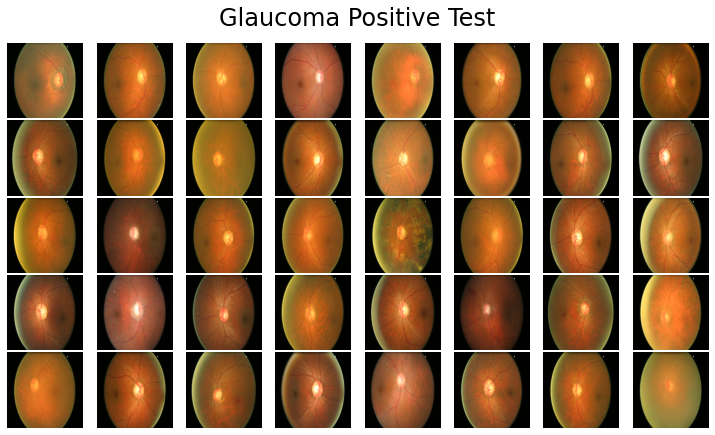

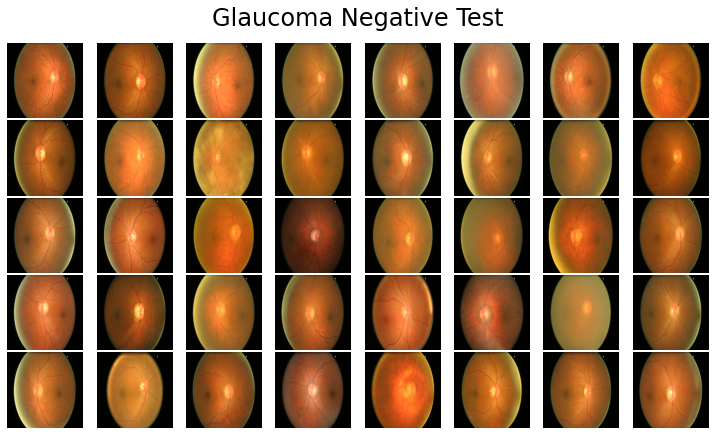

In [ ]:
# look at a random image
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

# plot Train Dataset
plot_images(glaucoma_positive_train_images, 'Glaucoma Positive Train')
plot_images(glaucoma_negative_train_images, 'Glaucoma Negative Train')

# plot Test Dataset
plot_images(glaucoma_positive_test_images, 'Glaucoma Positive Test')
plot_images(glaucoma_negative_test_images, 'Glaucoma Negative Test')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [ ]:
# normalize to interval of [0,1] for train dataset
glaucoma_positive_train_images = np.array(glaucoma_positive_train_images) / normalization_factor
glaucoma_negative_train_images = np.array(glaucoma_negative_train_images) / normalization_factor

# normalize to interval of [0,1] for test dataset
glaucoma_positive_test_images = np.array(glaucoma_positive_test_images) / normalization_factor
glaucoma_negative_test_images = np.array(glaucoma_negative_test_images) / normalization_factor

### **Train Test Split**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# images
X_train = np.concatenate((glaucoma_negative_train_images, glaucoma_positive_train_images), axis=0)
X_test = np.concatenate((glaucoma_negative_test_images, glaucoma_positive_test_images), axis=0)

# labels
y_train = np.concatenate((glaucoma_negative_train_labels, glaucoma_positive_train_labels), axis=0)
y_test = np.concatenate((glaucoma_negative_test_labels, glaucoma_positive_test_labels), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

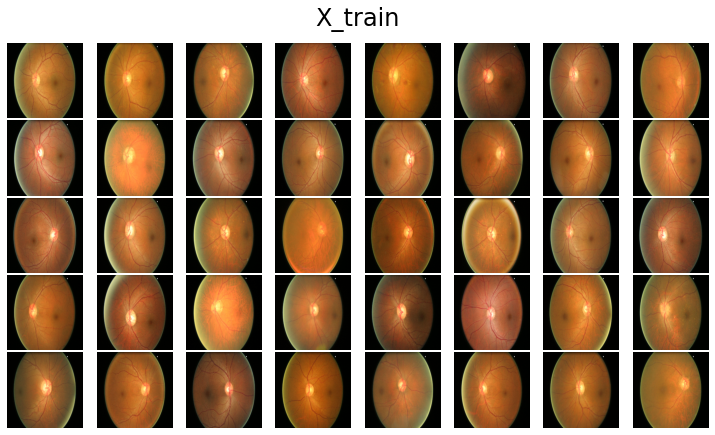

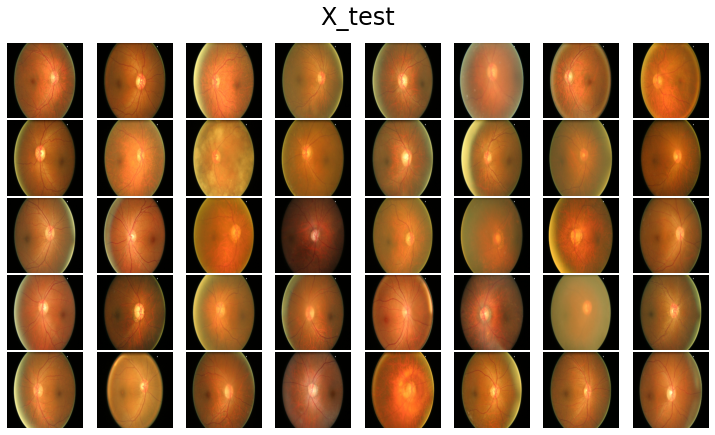

In [ ]:
plot_images(X_train, 'X_train')
plot_images(X_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing glaucoma_positive and glaucoma_negative for X_train and X_test

### **Building and Visualizing model**

In [ ]:
inception = InceptionResNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=500)

Epoch 1/500
20/20 [==============================] - 39s 850ms/step - loss: 8.8941 - accuracy: 0.6322 - val_loss: 7.7099 - val_accuracy: 0.2993
Epoch 2/500
20/20 [==============================] - 12s 561ms/step - loss: 5.3359 - accuracy: 0.6018 - val_loss: 1.8210 - val_accuracy: 0.5620
Epoch 3/500
20/20 [==============================] - 12s 565ms/step - loss: 2.7744 - accuracy: 0.6292 - val_loss: 2.1757 - val_accuracy: 0.6934
Epoch 4/500
20/20 [==============================] - 12s 561ms/step - loss: 1.9812 - accuracy: 0.6824 - val_loss: 1.1152 - val_accuracy: 0.7664
Epoch 5/500
20/20 [==============================] - 12s 564ms/step - loss: 1.7074 - accuracy: 0.7036 - val_loss: 0.7906 - val_accuracy: 0.7153
Epoch 6/500
20/20 [==============================] - 12s 561ms/step - loss: 1.3911 - accuracy: 0.7082 - val_loss: 0.9691 - val_accuracy: 0.7153
Epoch 7/500
20/20 [==============================] - 13s 605ms/step - loss: 1.8049 - accuracy: 0.6672 - val_loss: 1.6315 - val_accuracy:

In [ ]:
model.save('inception_resnet_v2_glaucoma.h5')

In [ ]:
model.save_weights('inception_resnet_v2_glaucoma.hdf5')

In [ ]:
model = load_model('inception_resnet_v2_glaucoma.h5')

### **Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

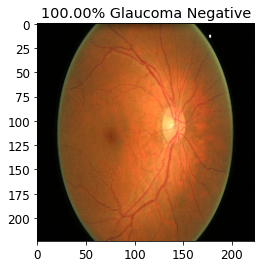

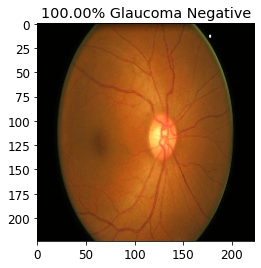

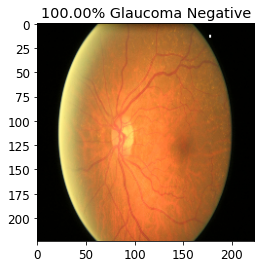

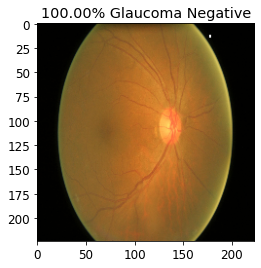

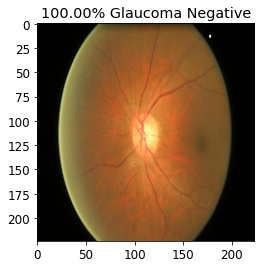

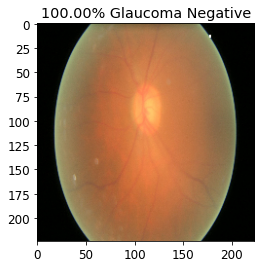

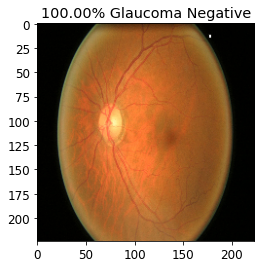

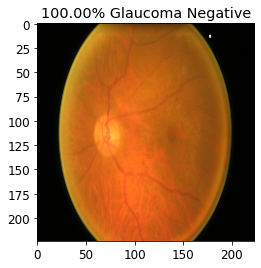

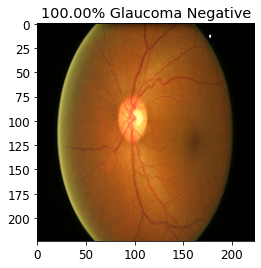

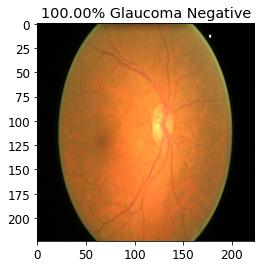

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Glaucoma Positive')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Glaucoma Negative')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

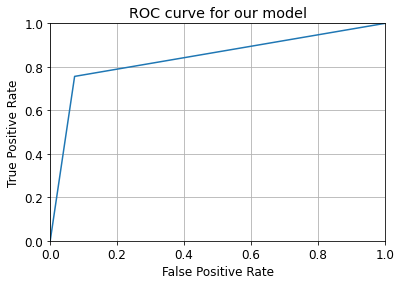

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


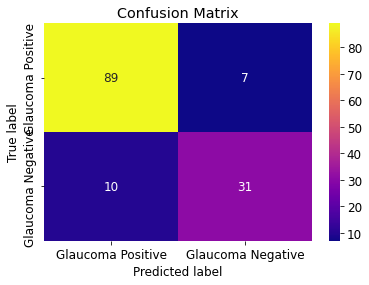

Confusion Matrix with Normalized Values


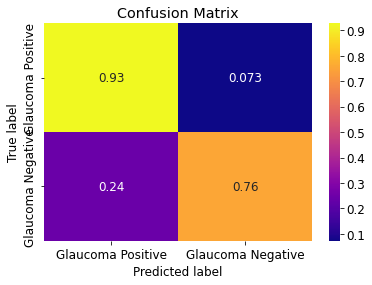

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['Glaucoma Positive','Glaucoma Negative']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        96
           1       0.82      0.76      0.78        41

    accuracy                           0.88       137
   macro avg       0.86      0.84      0.85       137
weighted avg       0.87      0.88      0.87       137



### **Accuracy and Loss Plots**

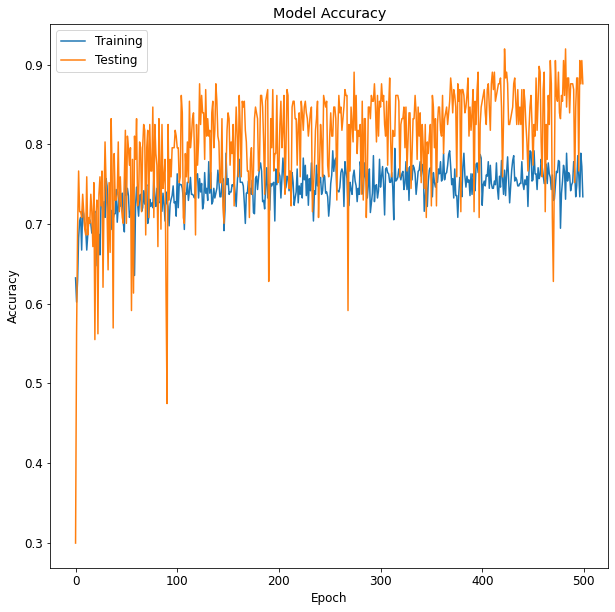

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_resnet_v2_glaucoma_accuracy.png')
plt.show()


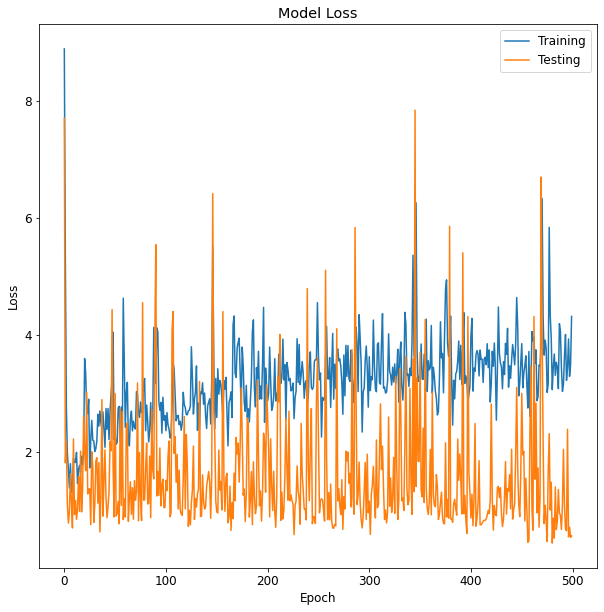

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_resnet_v2_glaucoma_loss.png')
plt.show()